Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.H9ROB1_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


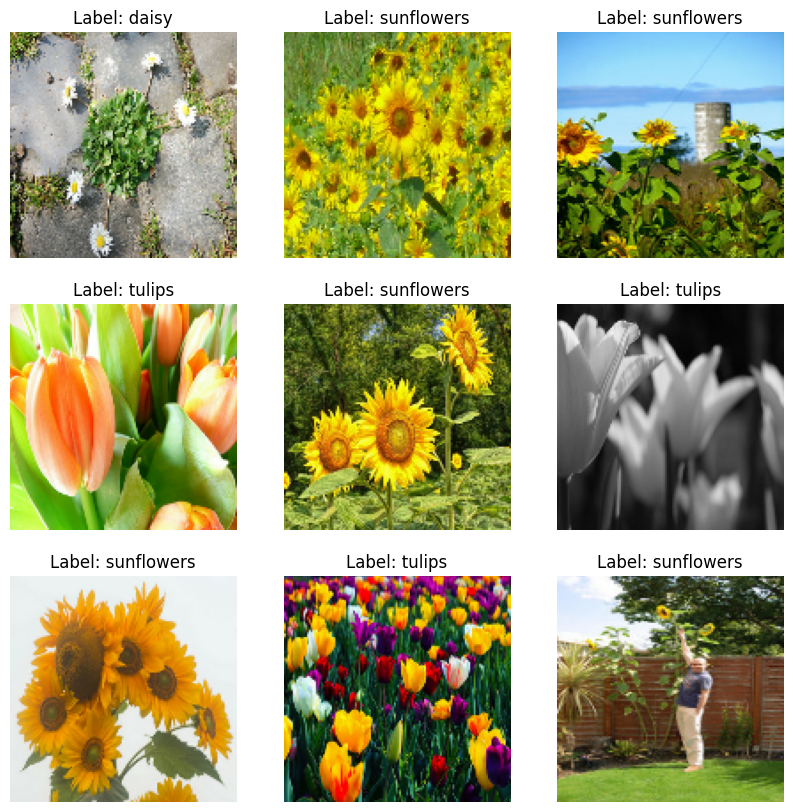

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 945ms/step - accuracy: 0.2747 - loss: 2.1825 - val_accuracy: 0.5354 - val_loss: 1.1375
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 872ms/step - accuracy: 0.5809 - loss: 1.0686 - val_accuracy: 0.5981 - val_loss: 1.0426
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 874ms/step - accuracy: 0.6971 - loss: 0.8021 - val_accuracy: 0.6185 - val_loss: 1.0716
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 910ms/step - accuracy: 0.8327 - loss: 0.4927 - val_accuracy: 0.6035 - val_loss: 1.2767
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 865ms/step - accuracy: 0.9222 - loss: 0.2530 - val_accuracy: 0.6117 - val_loss: 1.3930
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.6024 - loss: 1.4335

✅ Validation accuracy: 0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


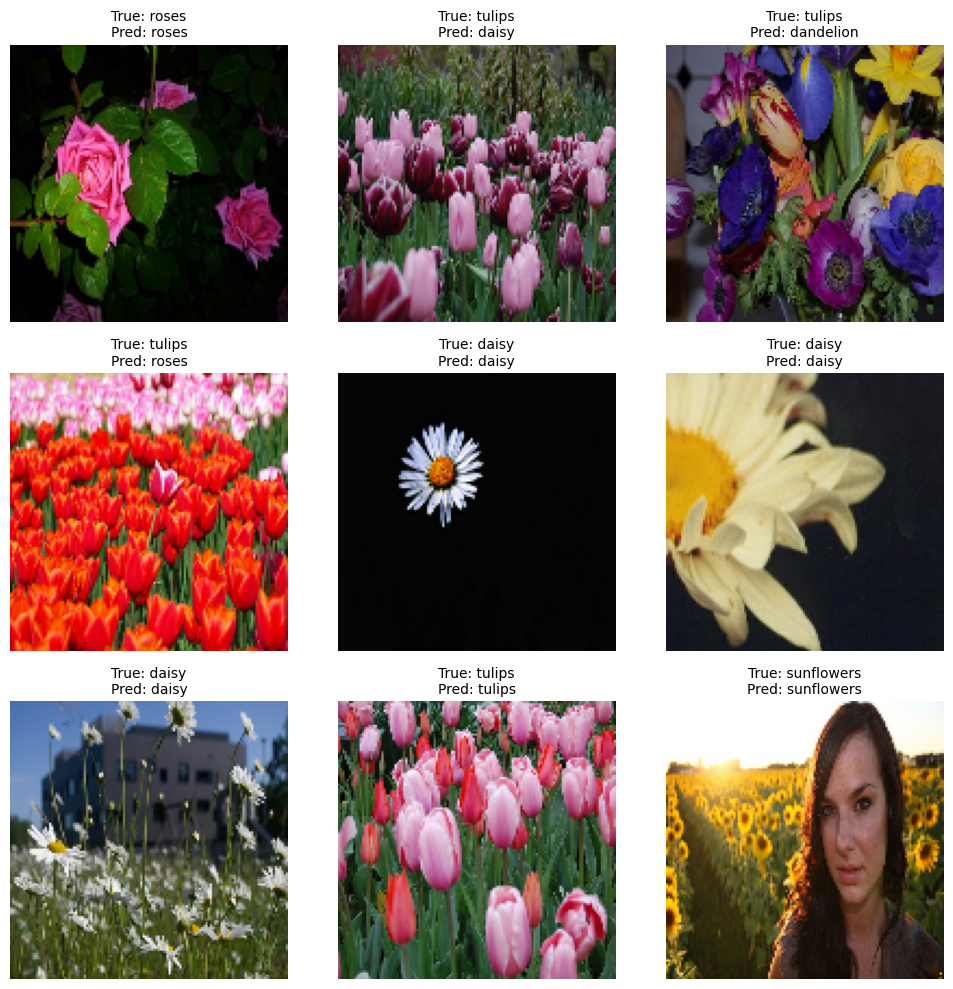

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# --- Load and preprocess the tf_flowers dataset ---
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 128
BATCH_SIZE = 32
NUM_CLASSES = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names  # For label display

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Visualize sample images ---
def show_batch(dataset):
    image_batch, label_batch = next(iter(dataset))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.title(f"Label: {class_names[label_batch[i].numpy()]}")
        plt.axis("off")
    plt.show()

show_batch(train_ds)

# --- Build a simple CNN model ---
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Train the model ---
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# --- Evaluate the model ---
test_loss, test_acc = model.evaluate(val_ds)
print(f"\n✅ Validation accuracy: {test_acc:.2f}")

# --- Show original images vs predicted labels ---
def show_predictions(dataset, model, num_images=9):
    image_batch, label_batch = next(iter(dataset))
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        true_label = class_names[label_batch[i].numpy()]
        pred_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(val_ds, model)
